In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.append("../")

from src.enablence_mux import EBMUX

In [2]:
target_grid_array = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 

wavelength_fabrication = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9

In [3]:
sppd_mc_data = xr.open_dataset("../simulation_data/sppd_clm_controller_1_mux_tec_tuning_output_power_clamp_mc_20240424_v0p1.nc")

In [4]:
sppd_mc_data

<xarray.Dataset>
Dimensions:                (idd_iter: 1001, idd_laser: 16, idd_eb: 1,
                            idd_sppd: 1, idd_wpe: 1, observable_stat: 16,
                            controller_observable: 5, lin_sweep_range: 3,
                            idd_mux: 1, idd_bw_lambda: 1)
Coordinates:
  * idd_iter               (idd_iter) int32 0 1 2 3 4 5 ... 996 997 998 999 1000
  * observable_stat        (observable_stat) object 'std' 'mean' ... 'min_agg_2'
  * idd_laser              (idd_laser) int32 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * controller_observable  (controller_observable) object 'drive_current' ......
  * lin_sweep_range        (lin_sweep_range) float64 0.1 0.2 0.3
  * idd_mux                (idd_mux) int32 0
  * idd_eb                 (idd_eb) int32 0
  * idd_sppd               (idd_sppd) int32 0
  * idd_bw_lambda          (idd_bw_lambda) int32 0
  * idd_wpe                (idd_wpe) int32 0
Data variables:
    enablence_mux_mc       (idd_iter, idd_laser, idd_eb) float64 ...
    sppd_laser_mc          (idd_iter, idd_laser, idd_sppd) float64 ...
    wpe_slope_factor_mc    (idd_iter, idd_laser, idd_wpe) float64 ...
    data_statistics_array  (idd_mux, idd_iter, idd_eb, idd_sppd, idd_bw_lambda, idd_wpe, lin_sweep_range, controller_observable, observable_stat, idd_laser) float64 ...
Attributes:
    description:  SPPD CLM Controller Monte Carlo Simulation simulations - da...

In [5]:
enablence_mux_bw_lambda = np.array([20])/17*0.1e-9
enablence_mux_3sigma = np.array([17])/17*0.1e-9
sppd_laser_3sigma = np.array([38])/17*0.1e-9
no_mux = np.array([0])
wpe_slope_3sigma = np.array([0.15])
lin_sweep_val_range = np.array([0.1,0.2,0.3])
mpd_current_clamp_range = np.array([40e-3])


no_lasers = 16
no_iterations = 1001

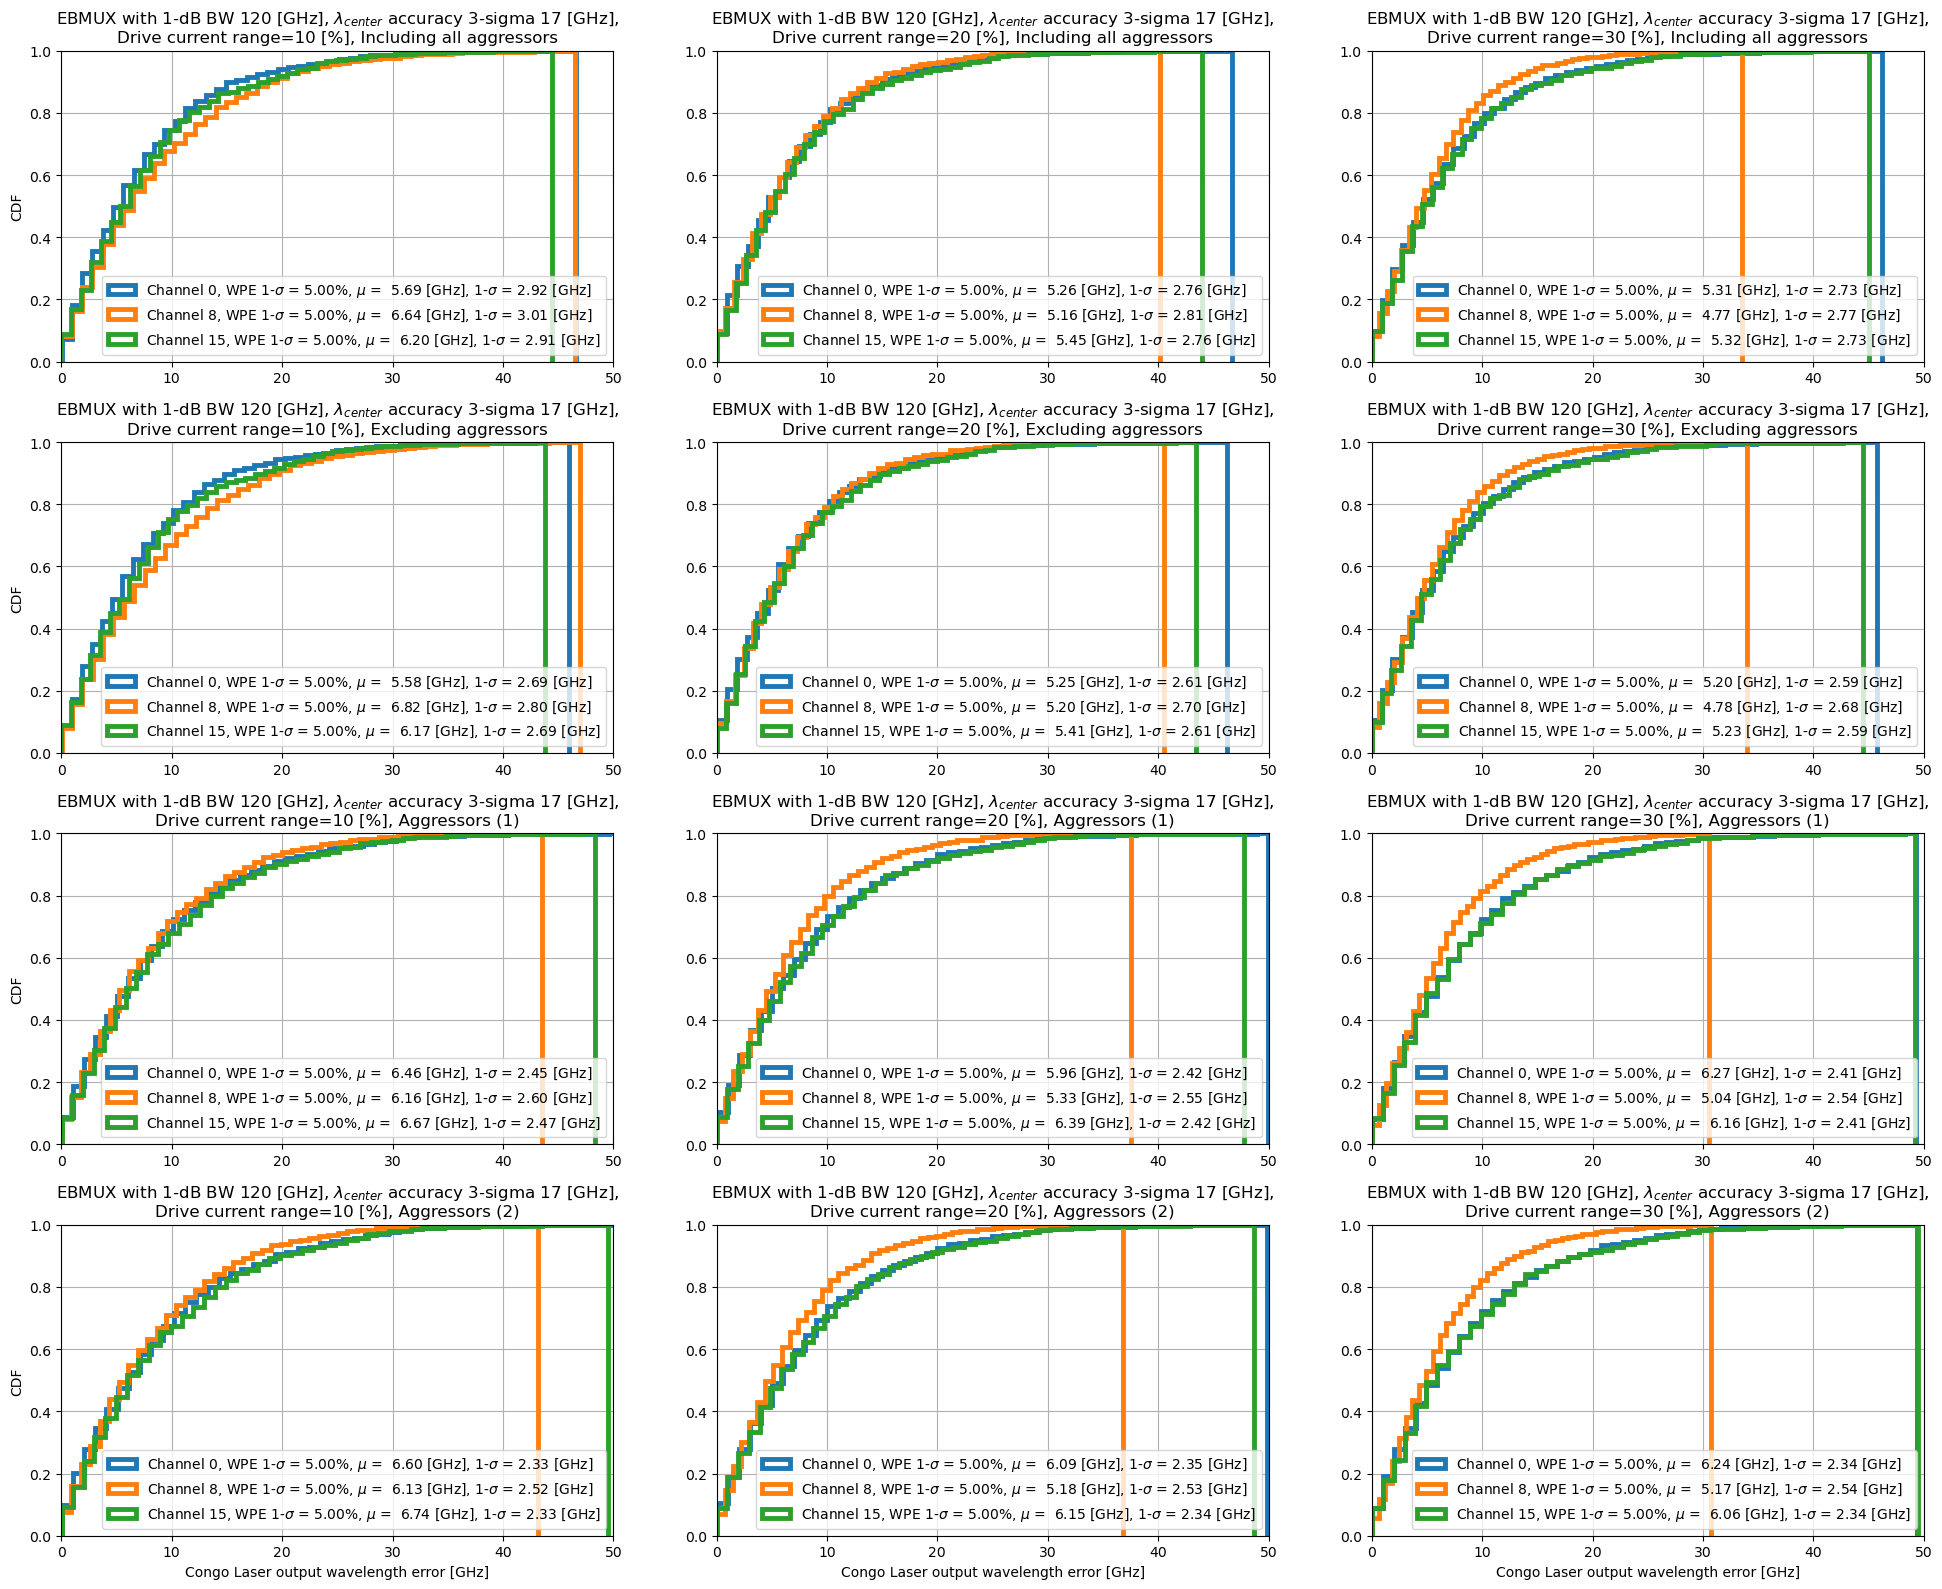

In [6]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            lambda_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_lambda').values
            median_lamda_ch = np.median(np.abs(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_lambda').values - target_grid_array[idd_laser_updated]))*1e9/0.1*17
            std_lamda_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'enablence_output_lambda').values)*1e9/0.1*17
            plt.hist(np.abs(lambda_ch - target_grid_array[idd_laser_updated])*1e9/0.1*17, density = True, cumulative= True, linewidth=3.5, histtype= 'step', bins=50, label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%'+r', $\mu$ = '+f' {np.abs(median_lamda_ch):0.2f} [GHz], '+f'1-$\sigma$ = '+f'{std_lamda_ch:0.2f} [GHz]')
            plt.legend()
            plt.xlim([0, 50])
            plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            if idd_stat == len(stat_attribute_combo) - 1:
              plt.xlabel('Congo Laser output wavelength error [GHz]')
            if idd_lin_sweep_val_range == 0:
              plt.ylabel('CDF')
plt.tight_layout()

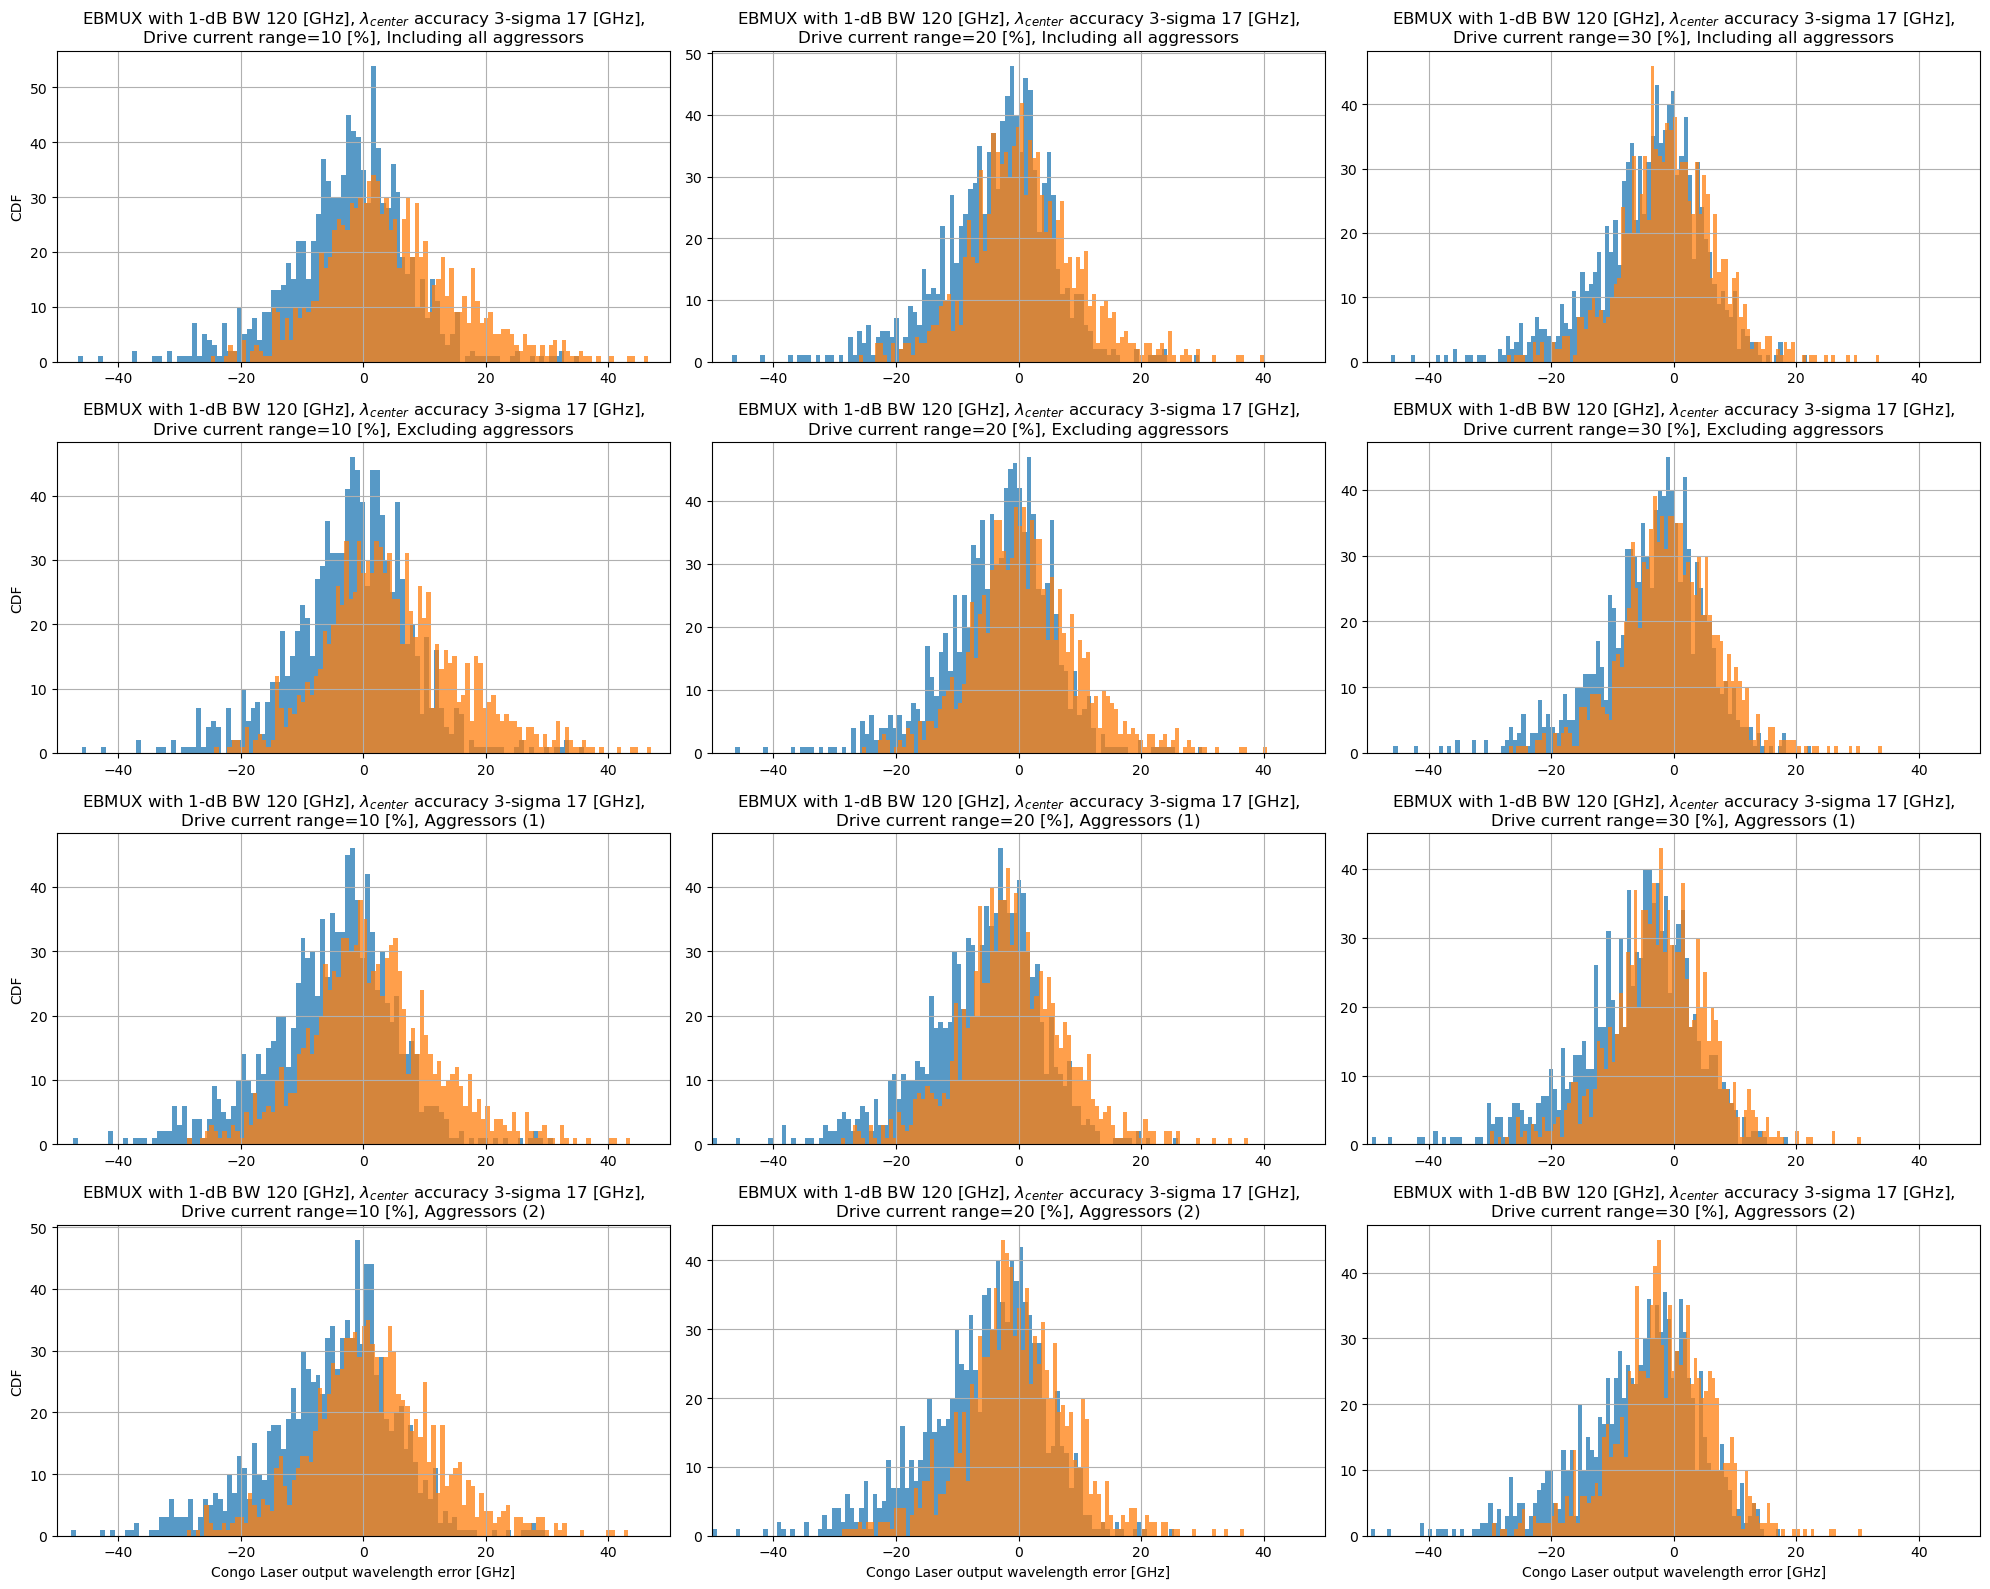

In [7]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(2):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      # for idd_wpe in range(len(wpe_slope_3sigma)):
      for idd_wpe in range(1):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            lambda_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_lambda').values
            median_lamda_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_lambda').values - target_grid_array[idd_laser_updated])*1e9/0.1*17
            std_lamda_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'enablence_output_lambda').values)*1e9/0.1*17
            plt.hist((lambda_ch - target_grid_array[idd_laser_updated])*1e9/0.1*17, linewidth=3.5, alpha = 0.75, bins=101, label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%'+r', $\mu$ = '+f' {np.abs(median_lamda_ch):0.2f} [GHz], '+f'1-$\sigma$ = '+f'{std_lamda_ch:0.2f} [GHz]')
            # plt.legend()
            plt.xlim([-50, 50])
            # plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            if idd_stat == len(stat_attribute_combo) - 1:
              plt.xlabel('Congo Laser output wavelength error [GHz]')
            if idd_lin_sweep_val_range == 0:
              plt.ylabel('CDF')
plt.tight_layout()

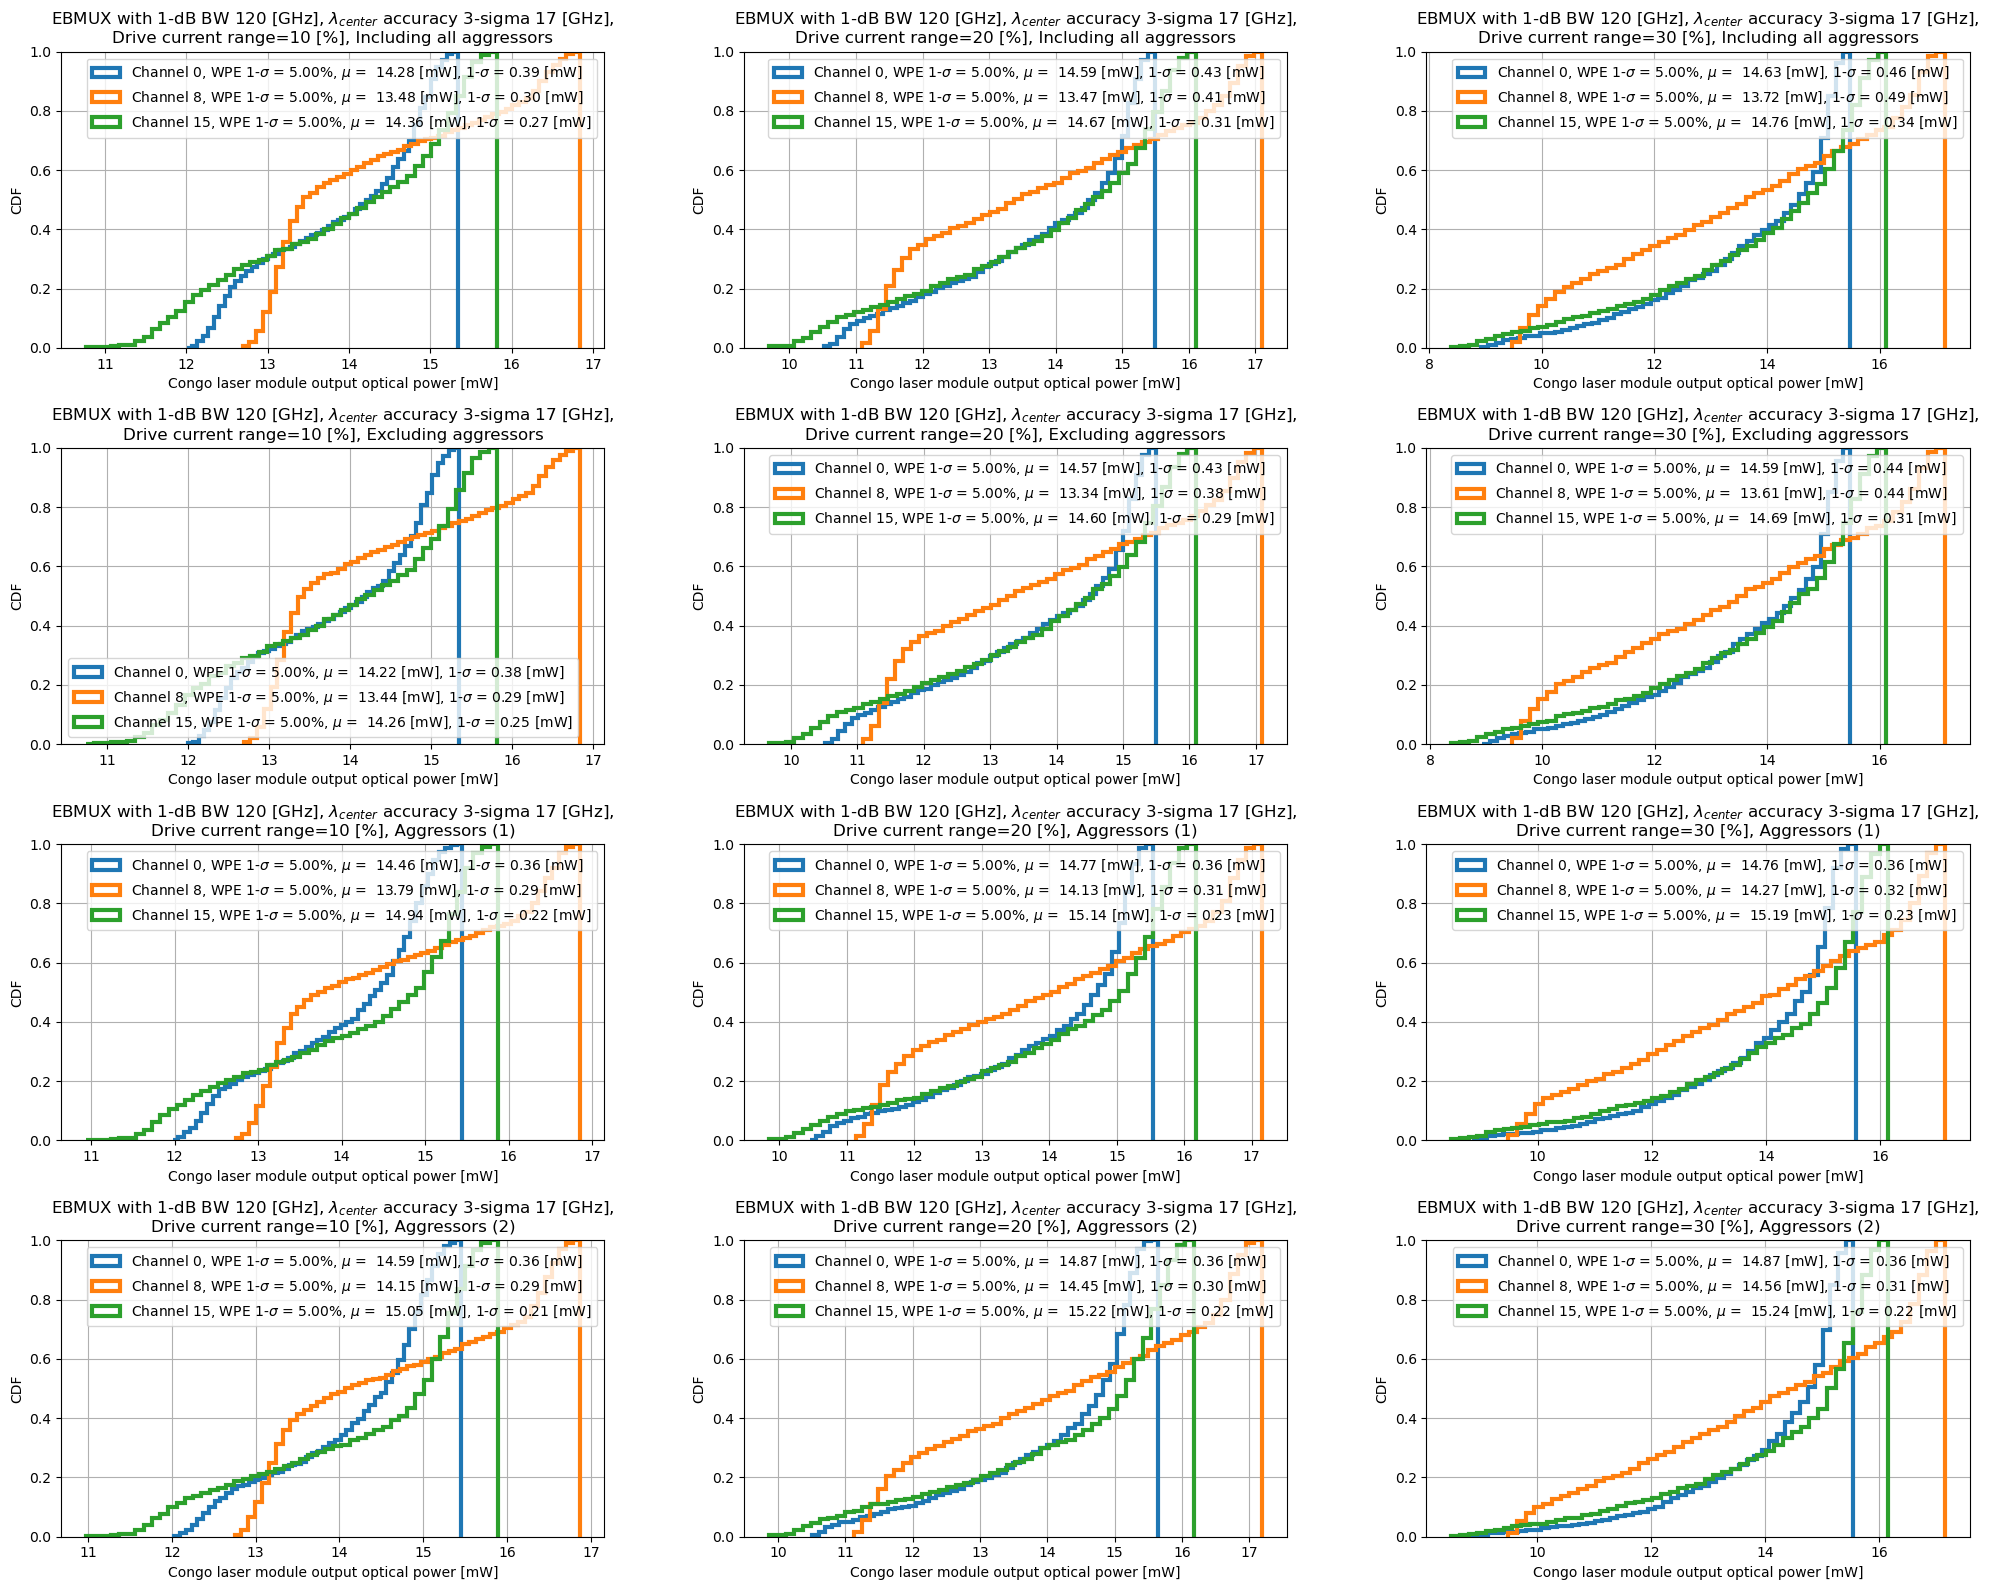

In [8]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_power').values*1e3
            median_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_power').values)*1e3
            std_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'enablence_output_power').values)*1e3
            plt.hist(pout_ch, density = True, cumulative= True, linewidth=3.0, histtype= 'step', bins=50, label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%'+r', $\mu$ = '+f' {np.abs(median_pout_ch):0.2f} [mW], '+f'1-$\sigma$ = '+f'{std_pout_ch:0.2f} [mW]')
            plt.legend()
            # plt.xlim([5, 20])
            plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            plt.xlabel('Congo laser module output optical power [mW]')
            plt.ylabel('CDF')
plt.tight_layout()

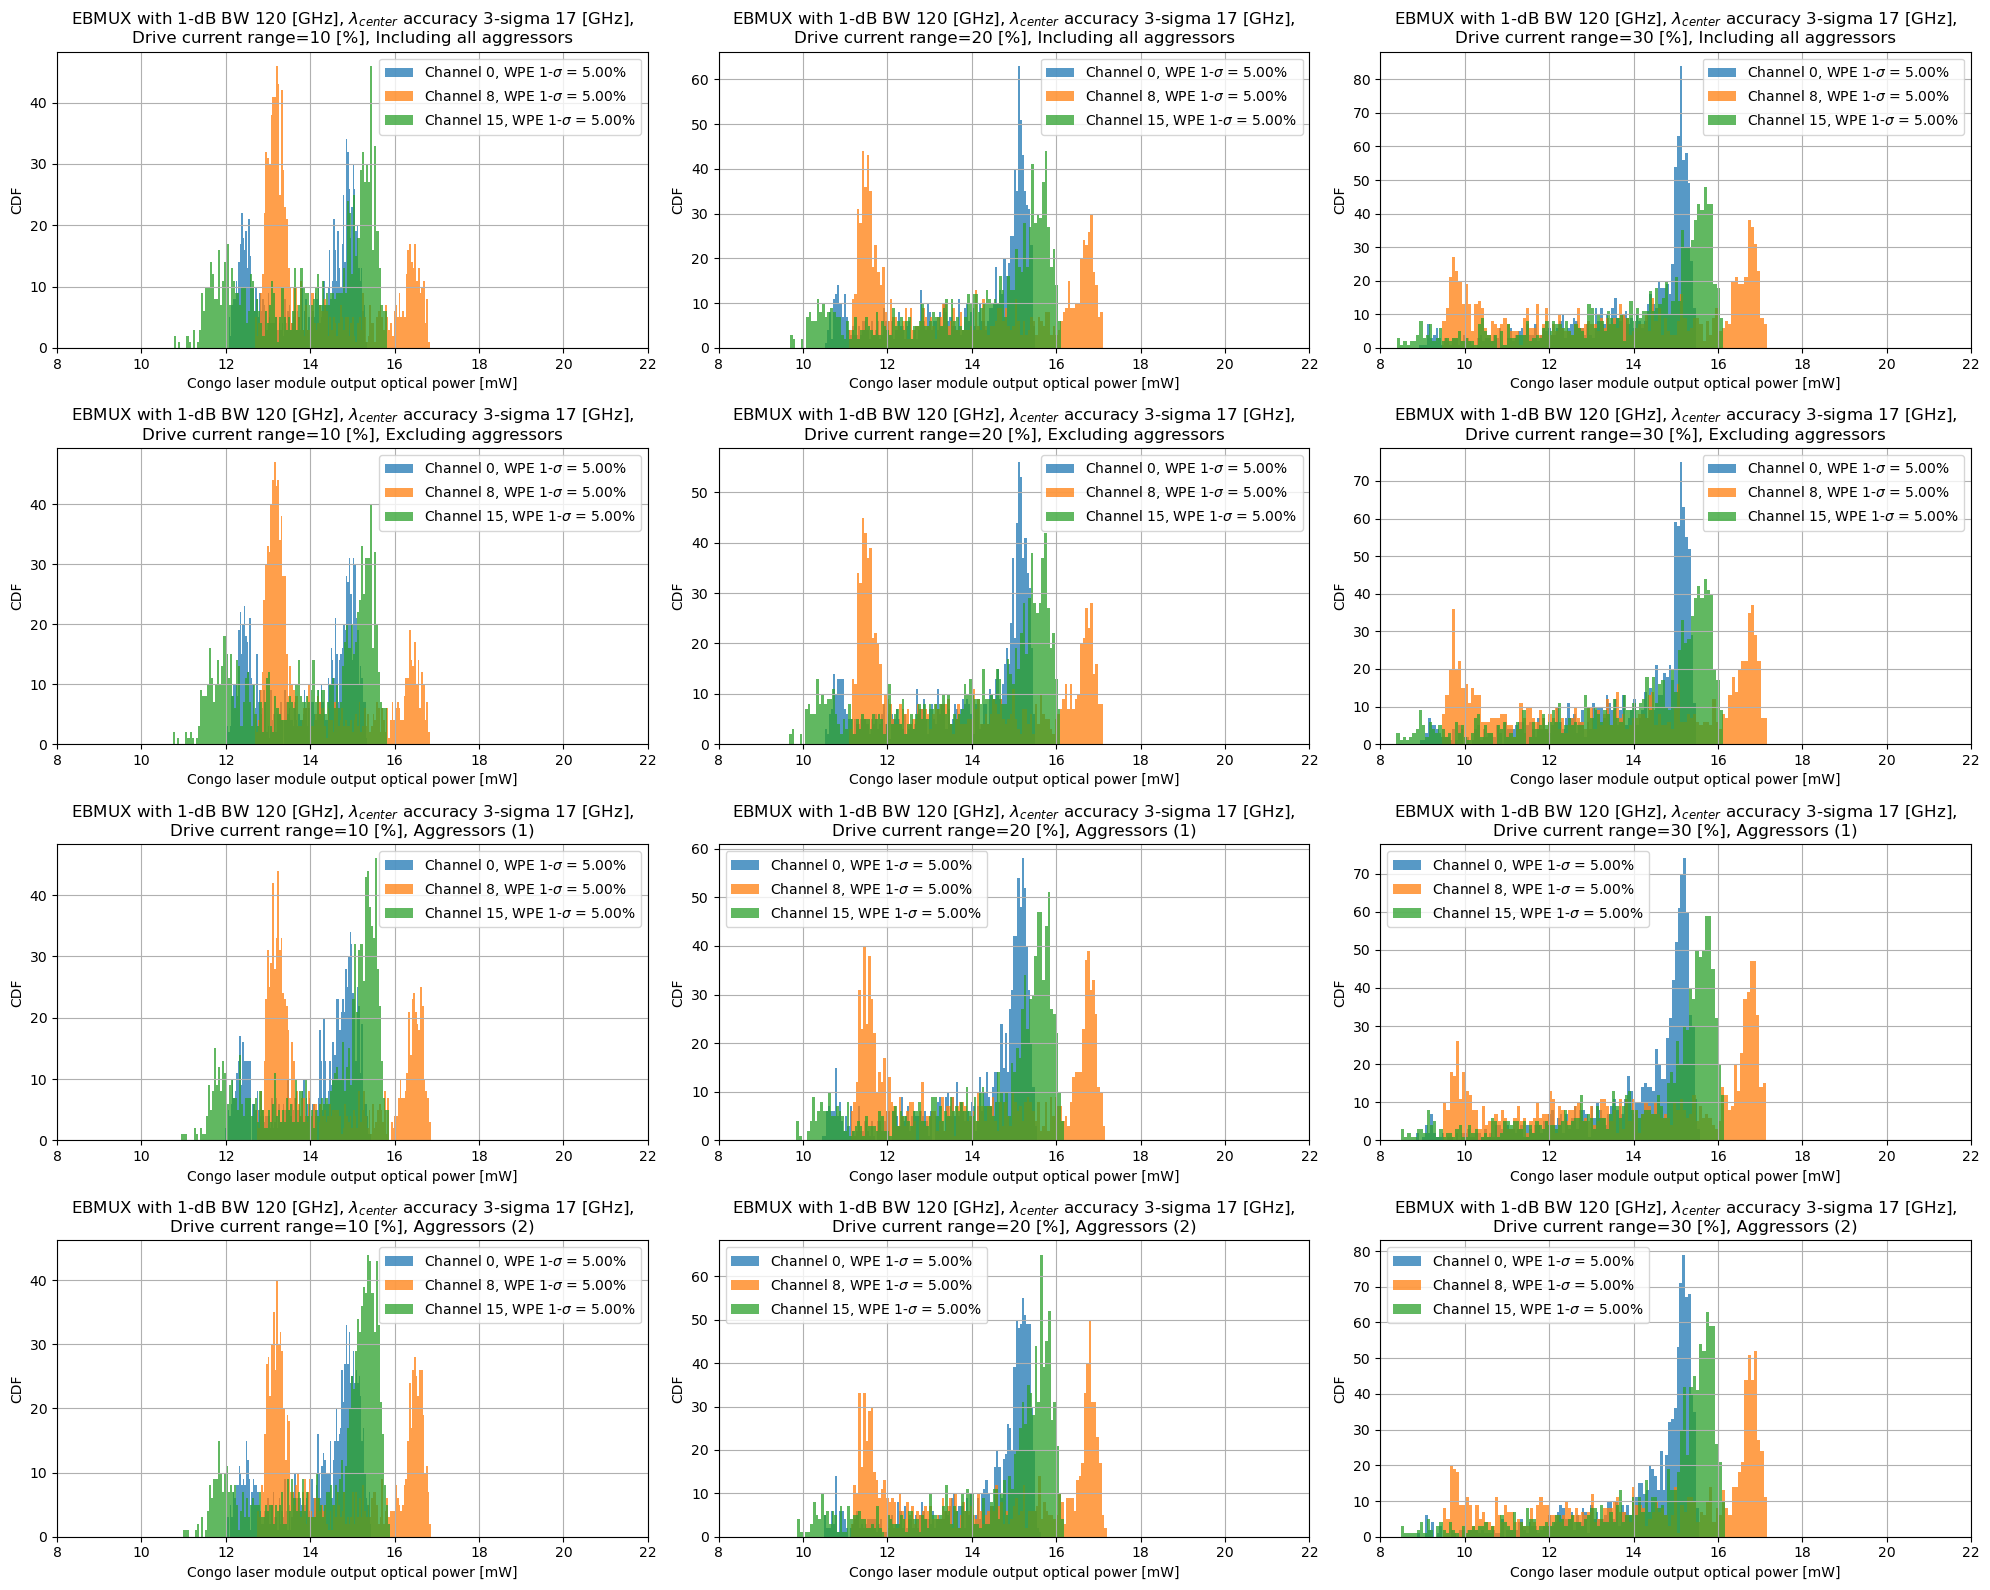

In [9]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_power').values*1e3
            median_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_power').values)*1e3
            std_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'enablence_output_power').values)*1e3
            plt.hist(pout_ch, linewidth=3.5, alpha = 0.75, bins=101,label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%')#+r', $\mu$ = '+f' {np.abs(median_pout_ch):0.2f} [mW], '+f'1-$\sigma$ = '+f'{std_pout_ch:0.2f} [mW]')
            plt.legend()
            plt.xlim([8, 22])
            # plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            plt.xlabel('Congo laser module output optical power [mW]')
            plt.ylabel('CDF')
plt.tight_layout()

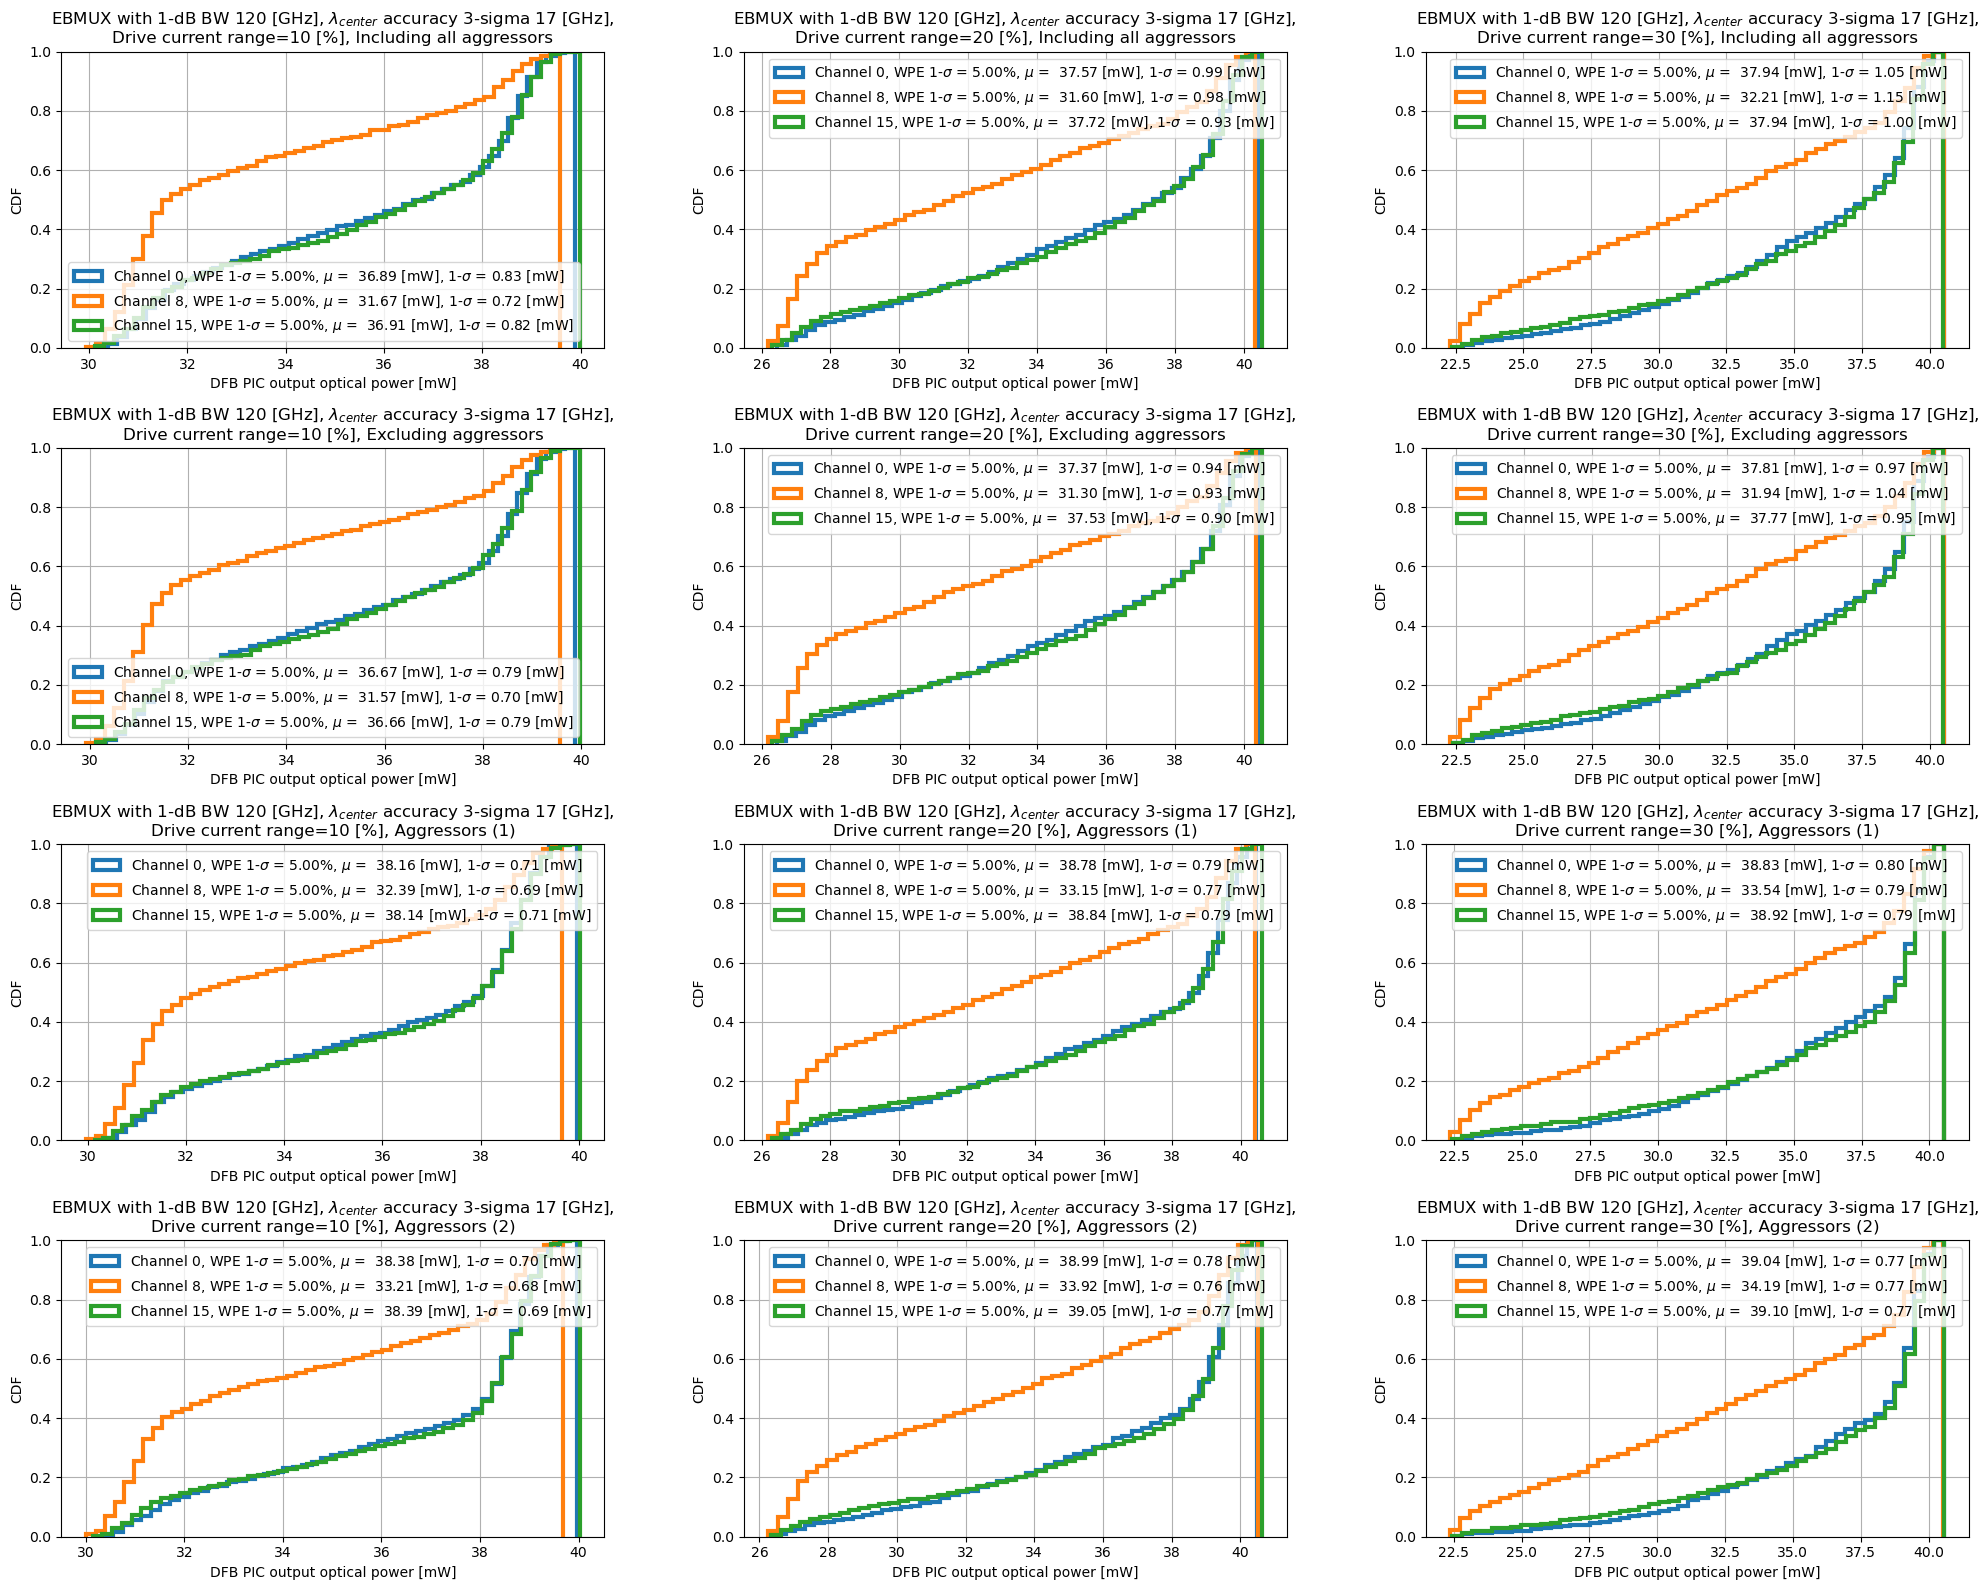

In [10]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_pout').values*1e3
            median_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_pout').values)*1e3
            std_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'sppd_pout').values)*1e3
            plt.hist(pout_ch, density = True, cumulative= True, linewidth=3.0, histtype= 'step', bins=50,  label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%'+r', $\mu$ = '+f' {np.abs(median_pout_ch):0.2f} [mW], '+f'1-$\sigma$ = '+f'{std_pout_ch:0.2f} [mW]')
            plt.legend()
            # plt.xlim([20, 50])
            plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            plt.xlabel('DFB PIC output optical power [mW]')
            plt.ylabel('CDF')
plt.tight_layout()

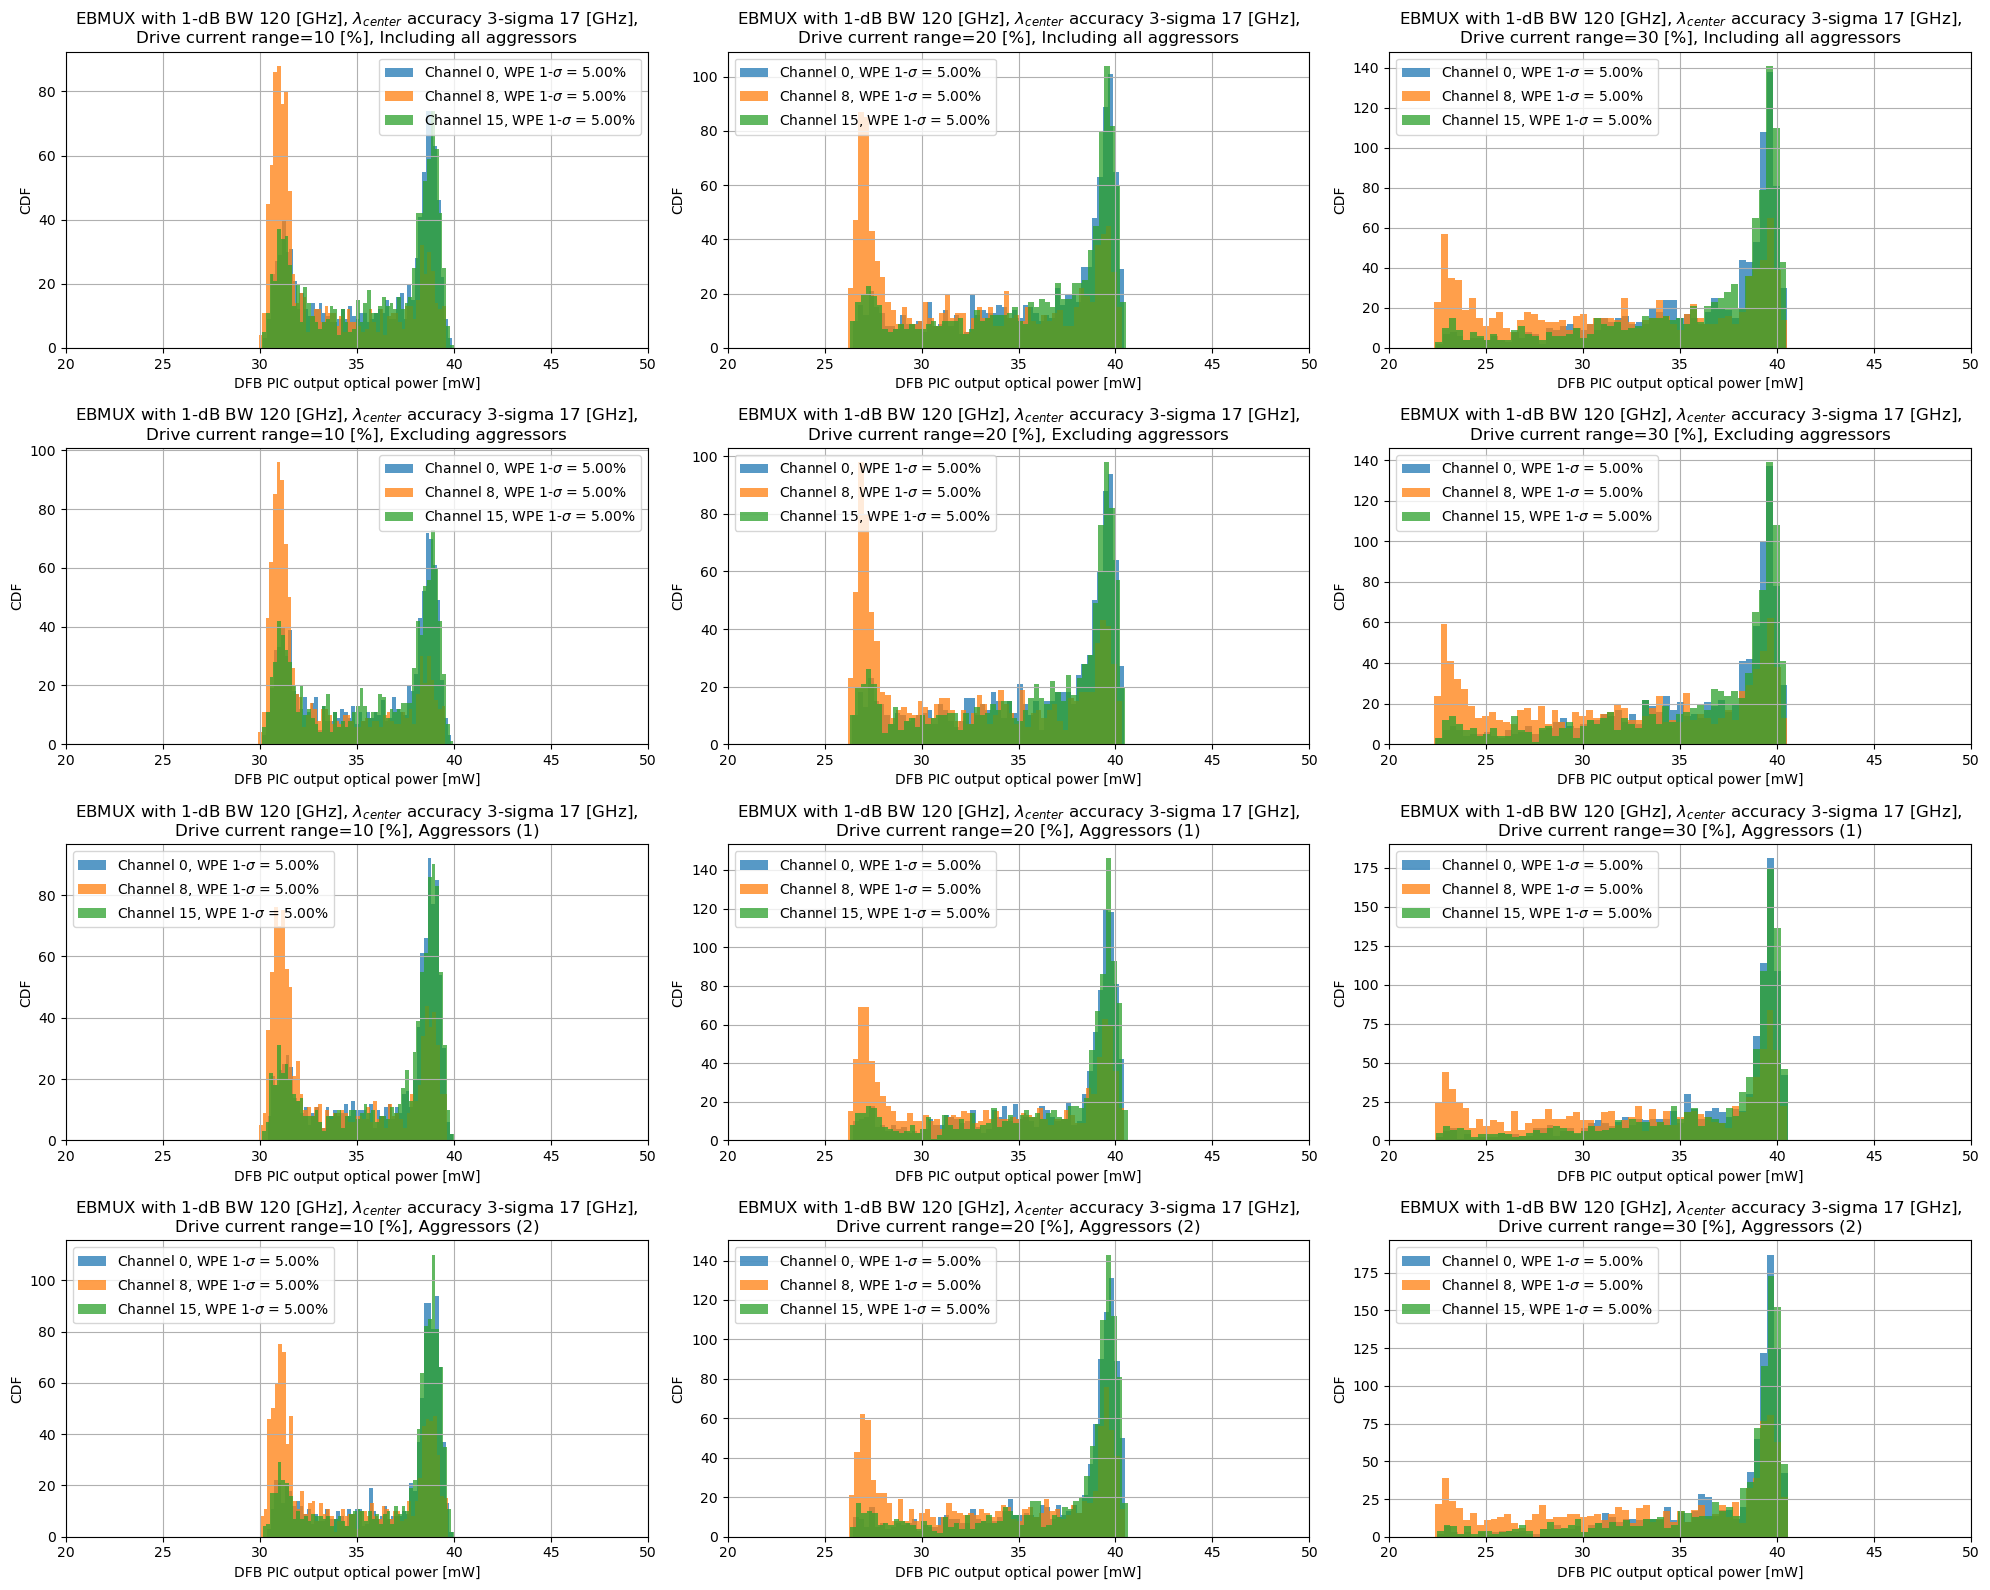

In [11]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_pout').values*1e3
            median_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_pout').values)*1e3
            std_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'sppd_pout').values)*1e3
            plt.hist(pout_ch, linewidth=3.5, alpha = 0.75, bins=51,label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%')#+r', $\mu$ = '+f' {np.abs(median_pout_ch):0.2f} [mW], '+f'1-$\sigma$ = '+f'{std_pout_ch:0.2f} [mW]')
            plt.legend()
            plt.xlim([20, 50])
            # plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            plt.xlabel('DFB PIC output optical power [mW]')
            plt.ylabel('CDF')
plt.tight_layout()

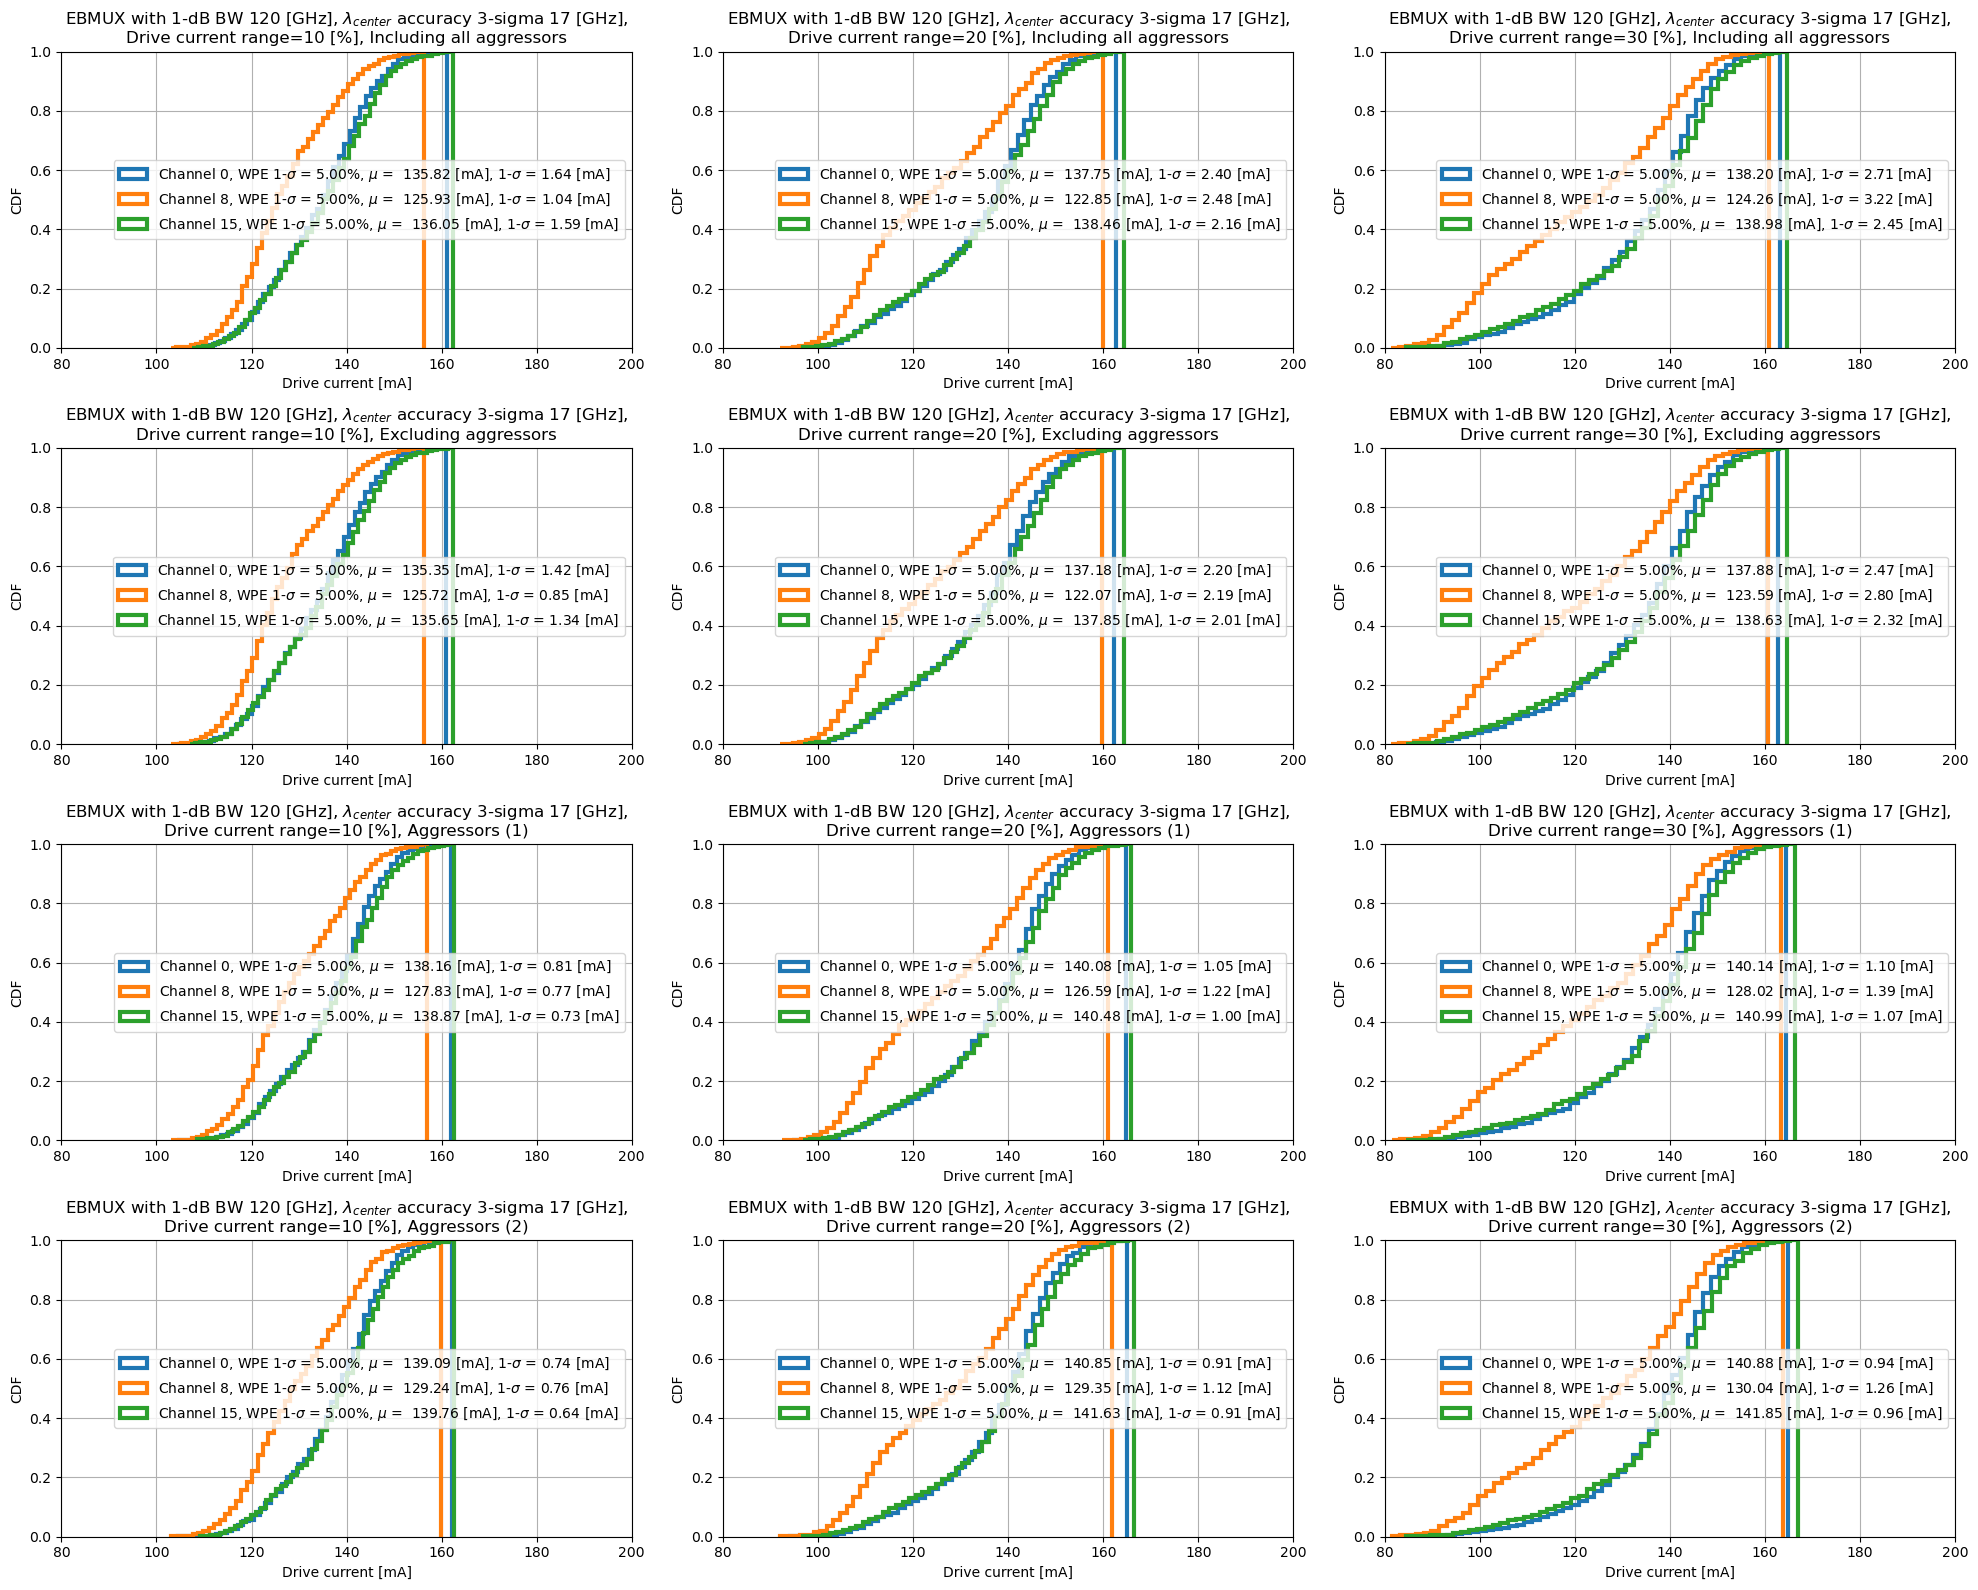

In [12]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'drive_current').values*1e3
            median_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'drive_current').values)*1e3
            std_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'drive_current').values)*1e3
            plt.hist(pout_ch, density = True, cumulative= True, linewidth=3.0, histtype= 'step', bins=50, label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%'+r', $\mu$ = '+f' {np.abs(median_pout_ch):0.2f} [mA], '+f'1-$\sigma$ = '+f'{std_pout_ch:0.2f} [mA]')
            plt.legend()
            plt.xlim([80, 200])
            plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            plt.xlabel('Drive current [mA]')
            plt.ylabel('CDF')
plt.tight_layout()

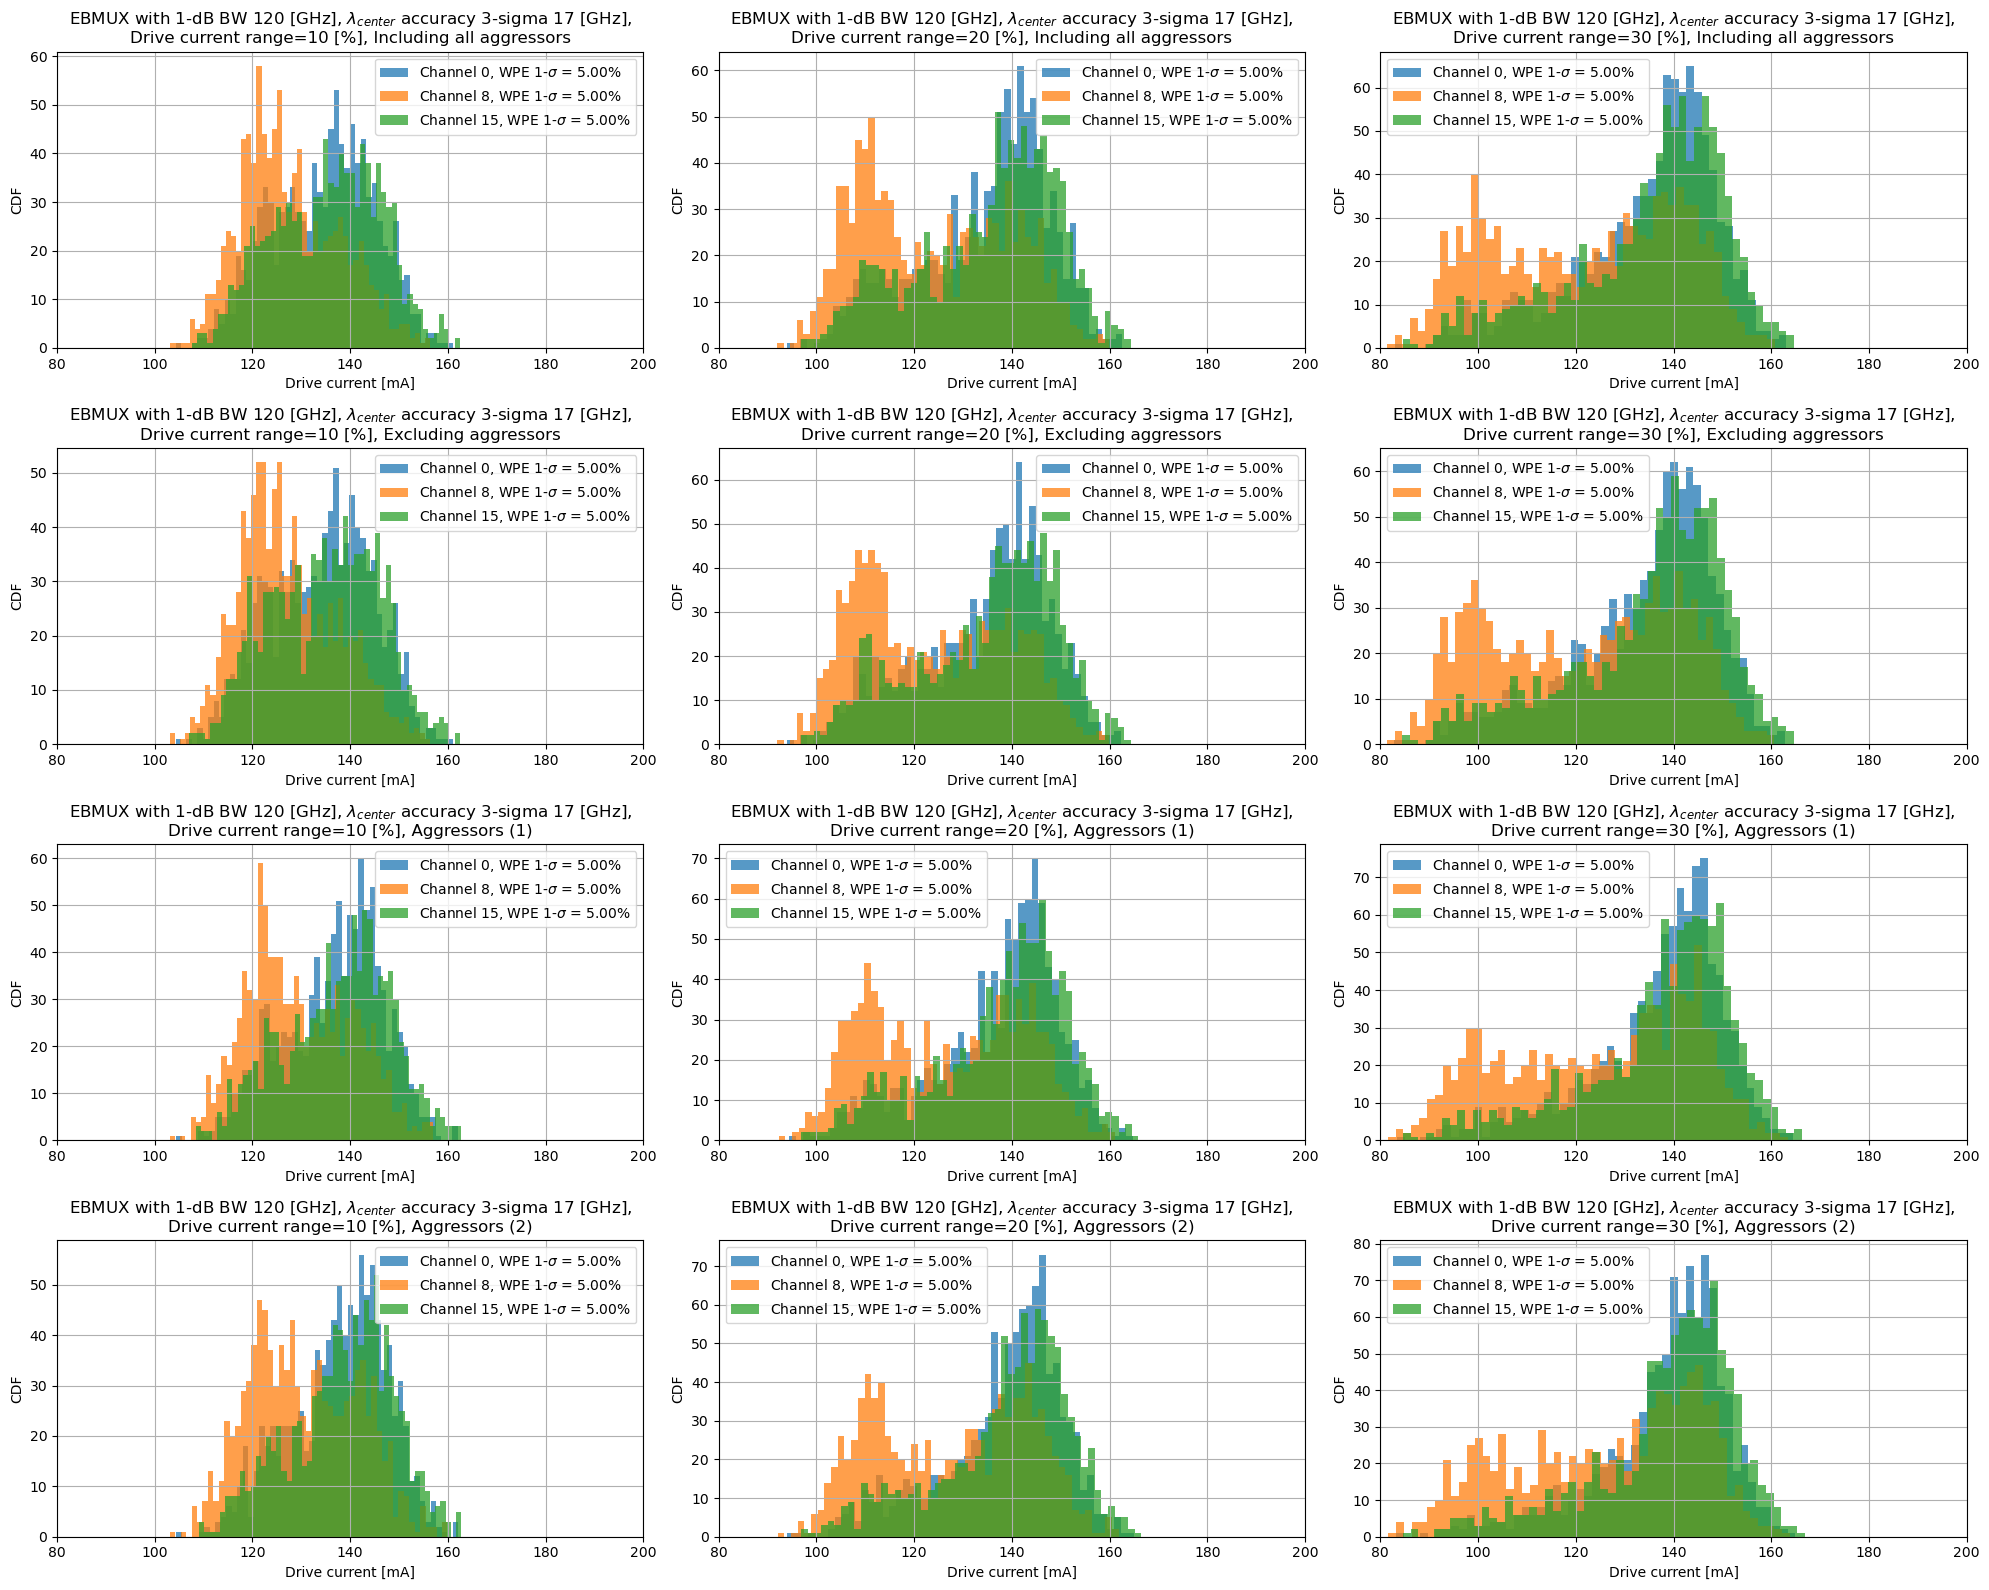

In [13]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'drive_current').values*1e3
            median_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'drive_current').values)*1e3
            std_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'drive_current').values)*1e3
            plt.hist(pout_ch,linewidth=3.5, alpha = 0.75, bins=51, label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%')#+r', $\mu$ = '+f' {np.abs(median_pout_ch):0.2f} [mA], '+f'1-$\sigma$ = '+f'{std_pout_ch:0.2f} [mA]')
            plt.legend()
            plt.xlim([80, 200])
            # plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            plt.xlabel('Drive current [mA]')
            plt.ylabel('CDF')
plt.tight_layout()

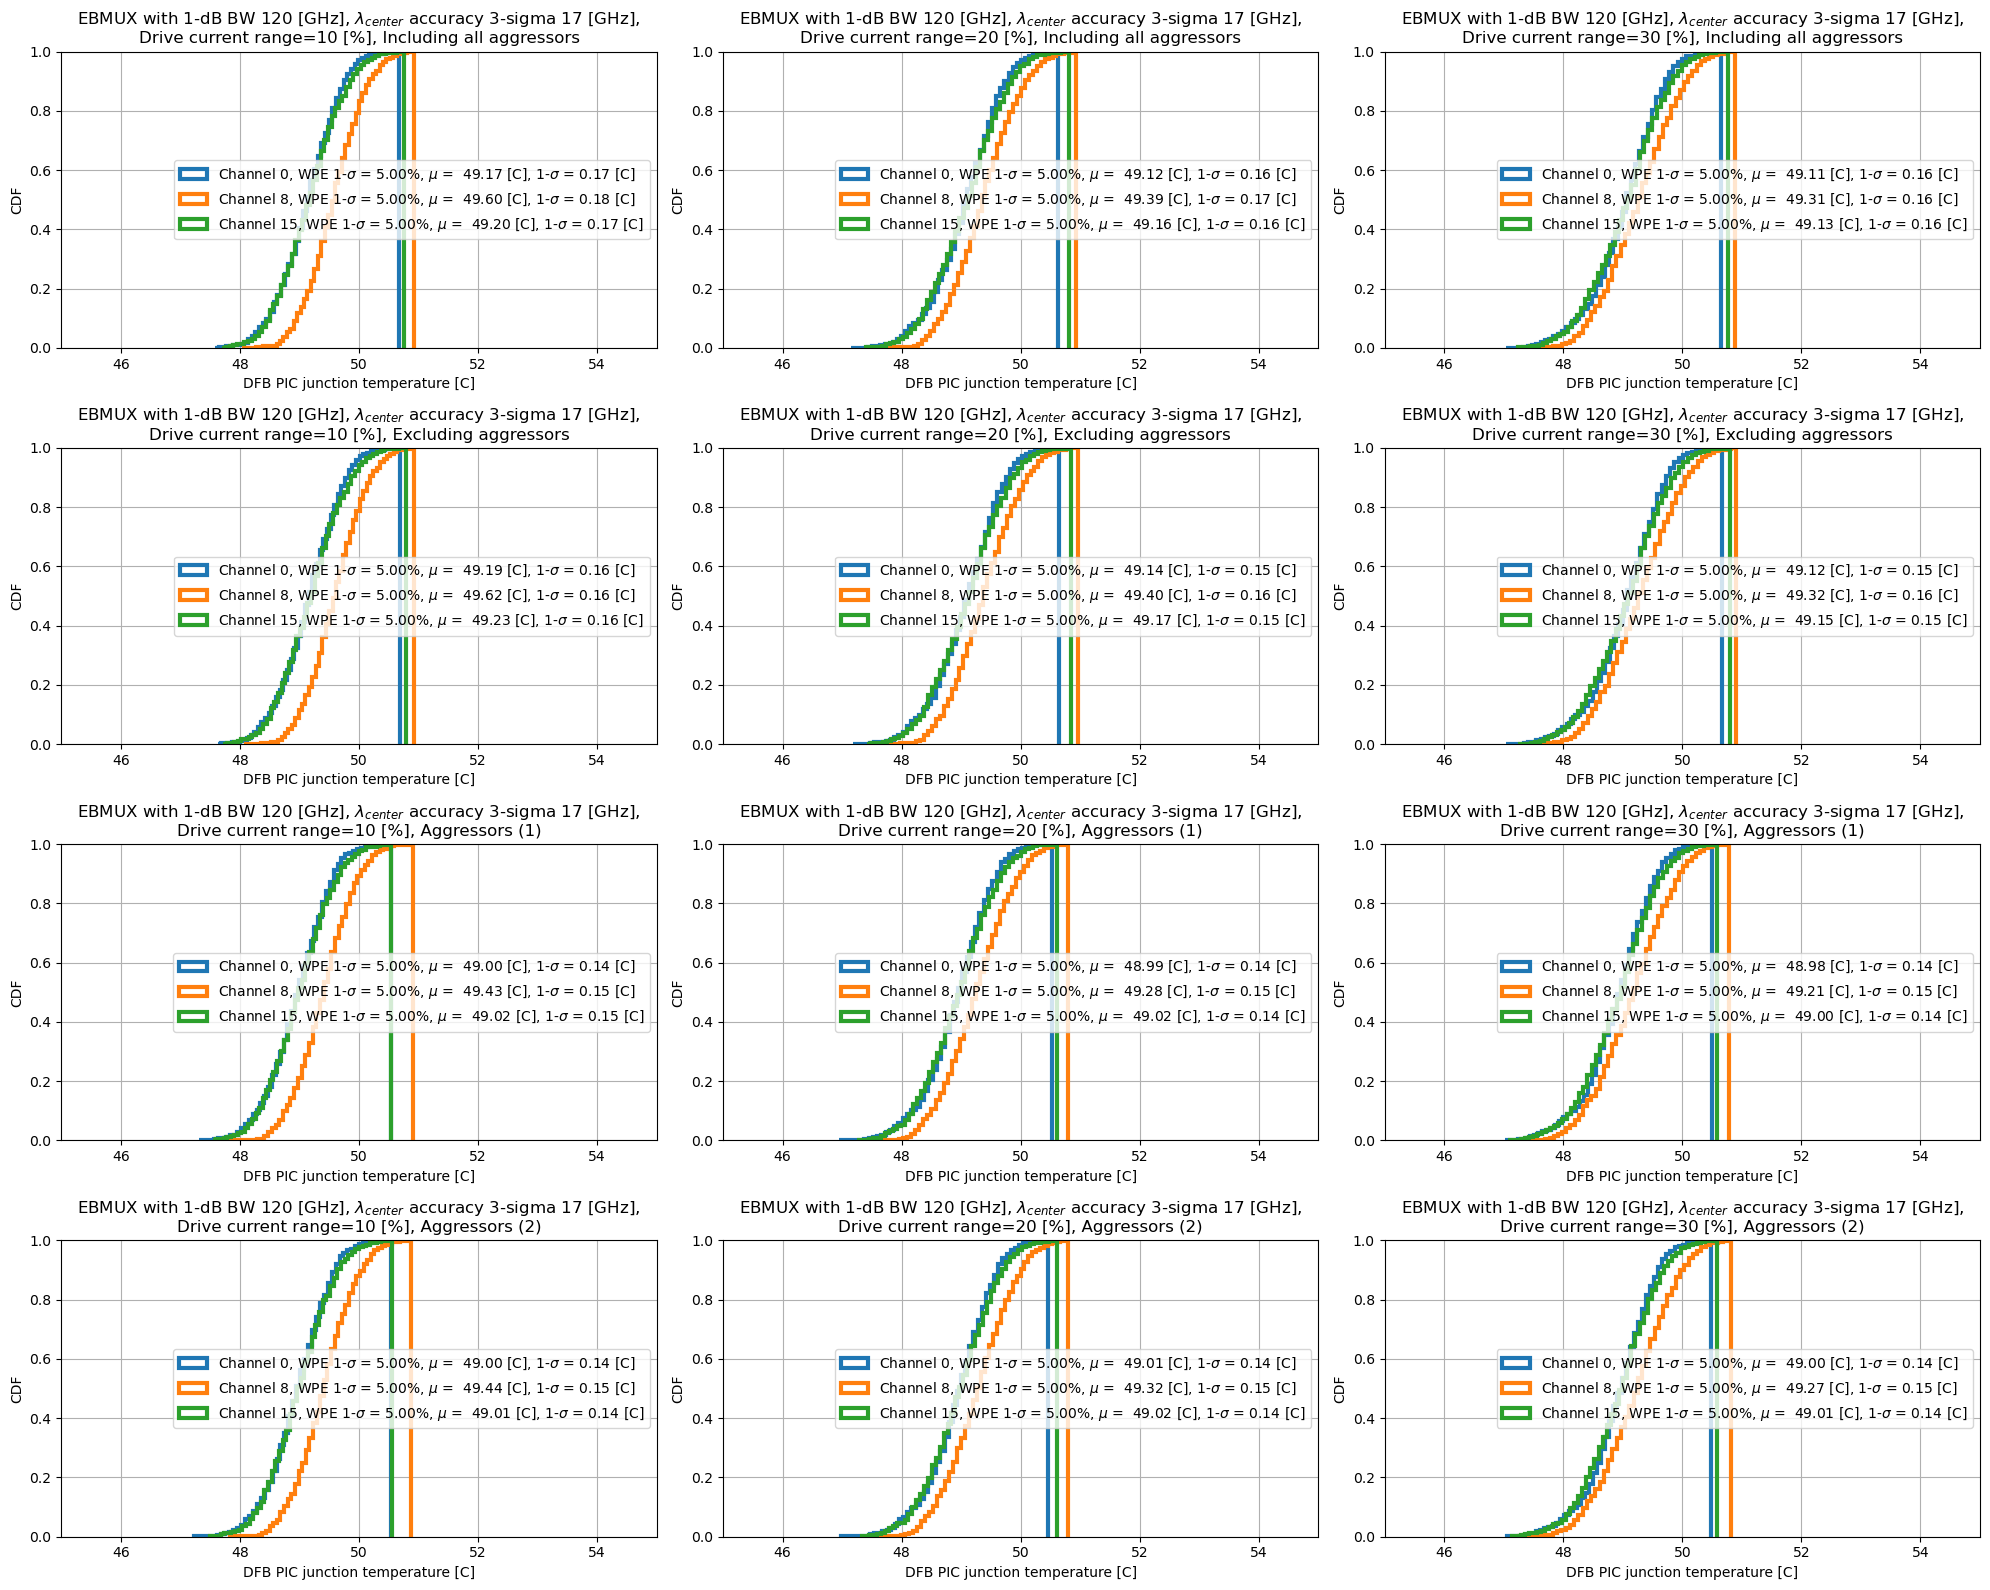

In [14]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_laser_junction_temperature').values-273.15
            median_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_laser_junction_temperature').values)-273.15
            std_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'sppd_laser_junction_temperature').values)
            plt.hist(pout_ch, density = True, cumulative= True, linewidth=3.0, histtype= 'step', bins=50, label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%'+r', $\mu$ = '+f' {np.abs(median_pout_ch):0.2f} [C], '+f'1-$\sigma$ = '+f'{std_pout_ch:0.2f} [C]')
            plt.legend()
            plt.xlim([45, 55])
            plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            plt.xlabel('DFB PIC junction temperature [C]')
            plt.ylabel('CDF')
plt.tight_layout()

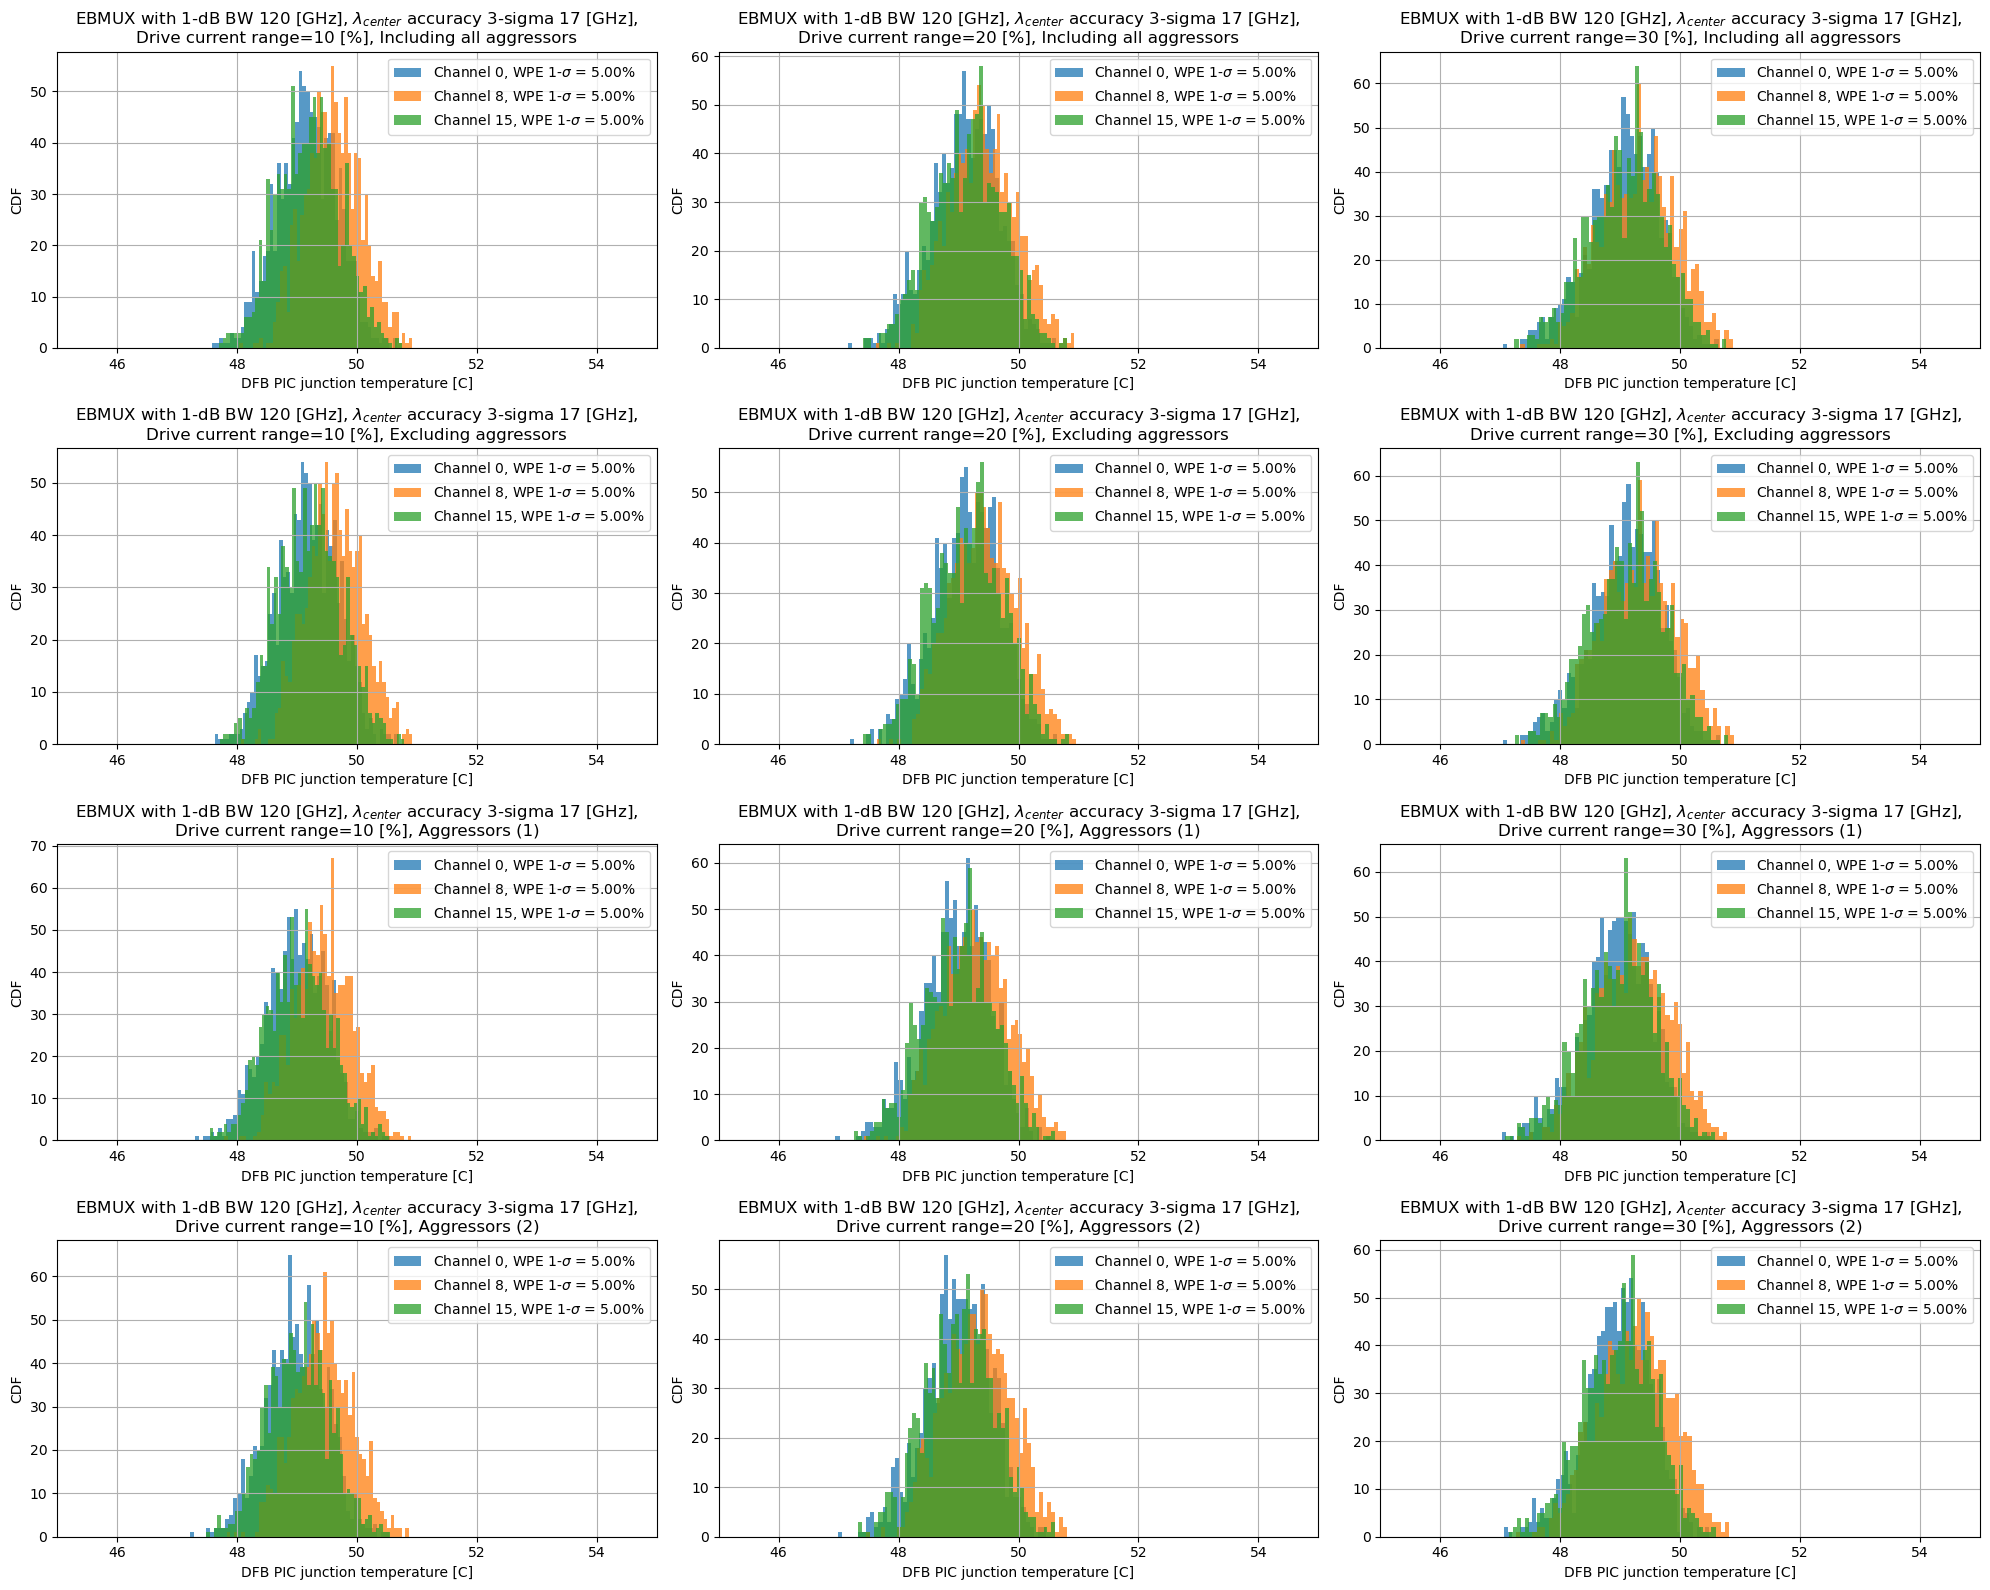

In [15]:
stat_attribute_combo = ["", "_no_agg", "_agg_1", "_agg_2"]
stat_attribute_title = ["Including all aggressors", "Excluding aggressors", "Aggressors (1)", "Aggressors (2)"]
plt.figure(figsize=(20,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_laser_junction_temperature').values-273.15
            median_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_laser_junction_temperature').values)-273.15
            std_pout_ch = np.median(sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range], observable_stat = 'std'+stat_value, controller_observable = 'sppd_laser_junction_temperature').values)
            plt.hist(pout_ch, linewidth=3.5, alpha = 0.75, bins=51, label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%')#+r', $\mu$ = '+f' {np.abs(median_pout_ch):0.2f} [C], '+f'1-$\sigma$ = '+f'{std_pout_ch:0.2f} [C]')
            plt.legend()
            plt.xlim([45, 55])
            # plt.ylim([0,1])
            plt.grid(True)
            plt.title(f'EBMUX with 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%], '+stat_attribute_title[idd_stat])
            plt.xlabel('DFB PIC junction temperature [C]')
            plt.ylabel('CDF')
plt.tight_layout()